# Imports

In [27]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D 
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential, model_from_json, Model

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, LeakyReLU, Activation
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, SeparableConv2D
from keras.layers import Input, ZeroPadding2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D

import tensorflow as tf

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


RSEED = 3

# Balanced c/ Data Augmentation vs Balanced sem

In [28]:
n_epochs = 25       # nº de epochs
n_steps = 131       # steps por epoch, nem é preciso colocar ao fazer o fit por é o valor default
image_size = 180    # tamanho na imagem para o qual vamos normalizar -> [180,180]

**1. Setup Train e Validation Data**

In [29]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 180
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #read black and white
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [30]:
def get_train(indx):

    data = get_data('C:\\Users\\OMEN\OneDrive - Universidade de Aveiro\\Mestrado\\4 ano\\1 semestre\\AIA\\Projeto 1\\chest_xray\\train')

    #print(data)
    l = []
    count_0 = 0
    count_1 = 0
    for i in data:
        if(i[1] == 0):
            l.append(labels[0])
            count_0 += 1
        else:
            l.append(labels[1])
            count_1 += 1

    if indx == 1:
        sns.set_style('darkgrid')
        sns.countplot(l)

        plt.figure(figsize = (5,5))
        plt.imshow(data[1][0])
        plt.title(labels[data[0][1]])

        plt.figure(figsize = (5,5))
        plt.imshow(data[-1][0])
        plt.title(labels[data[-1][1]])

    x = []
    y = []

    for feature, label in data:
        x.append(feature)
        y.append(label)

    x = np.array(x) / 180
    y = np.array(y).reshape((-1,1))

    return x,y

In [31]:
x,y = get_train(0)

print(x.shape)
print(y.shape)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)


**2. Setup Test data**

In [32]:
def get_test(indx):

    data = get_data('C:\\Users\\OMEN\OneDrive - Universidade de Aveiro\\Mestrado\\4 ano\\1 semestre\\AIA\\Projeto 1\\chest_xray\\test')
    
    #print(data)
    l = []
    count_0 = 0
    count_1 = 0
    for i in data:
        if(i[1] == 0):
            l.append(labels[0])
            count_0 += 1
        else:
            l.append(labels[1])
            count_1 += 1

    if indx == 1:
        sns.set_style('darkgrid')
        sns.countplot(l)

        plt.figure(figsize = (5,5))
        plt.imshow(data[1][0])
        plt.title(labels[data[0][1]])

        plt.figure(figsize = (5,5))
        plt.imshow(data[-1][0])
        plt.title(labels[data[-1][1]])

    x = []
    y = []

    for feature, label in data:
        x.append(feature)
        y.append(label)

    x = np.array(x) / 180
    y = np.array(y).reshape((-1,1))

    return x,y

In [33]:
x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

(624, 180, 180, 3)
(624, 1)


C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Visualizar Data

In [34]:
# Imagens de TREINO e VALIDAÇÃO
files_train = tf.io.gfile.glob('chest_xray/train/*/*')

# Fazer a divisão dos ficheiros de treino em 80% para treino e 20% para teste
train_imgs, val_imgs = train_test_split(files_train, test_size=0.2, random_state=RSEED)

# Imagens de TESTE
test_imgs = tf.io.gfile.glob('chest_xray/test/*/*')

In [35]:
norm_IMG_Train = 0
arry_hist_train = []

for img in train_imgs:
    if "NORMAL" in img:
        norm_IMG_Train = norm_IMG_Train + 1
        arry_hist_train.append(0)

print("Normal images in the Training Set: ", norm_IMG_Train)


pneu_IMG_Train = 0

for img in train_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Train = pneu_IMG_Train + 1
        arry_hist_train.append(1)

print("Pneumonia images in the Training Set: ", pneu_IMG_Train)

total_img_Train = norm_IMG_Train + pneu_IMG_Train
print("Total images in Training Set: ", total_img_Train)

#-----------------------------
print(' ')
#-----------------------------


# Fazer a contagem de imagens de Validação


norm_IMG_Val = 0
arry_hist_val = []

for img in val_imgs:
    if "NORMAL" in img:
        norm_IMG_Val = norm_IMG_Val + 1
        arry_hist_val.append(0)

print("Normal images in the Validation Set: ", norm_IMG_Val)


pneu_IMG_Val = 0

for img in val_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Val = pneu_IMG_Val + 1
        arry_hist_val.append(1)

print("Pneumonia images in the Validation Set: ", pneu_IMG_Val)

total_img_Val = norm_IMG_Val + pneu_IMG_Val
print("Total images in Validation Set: ", total_img_Val)

#-----------------------------
print(' ')
#-----------------------------


# Fazer a contagem de imagens de Teste


norm_IMG_Test = 0
arry_hist_test = []

for img in test_imgs:
    if "NORMAL" in img:
        norm_IMG_Test = norm_IMG_Test + 1
        arry_hist_test.append(0)

print("Normal images in the Testing Set: ", norm_IMG_Test)


pneu_IMG_Test = 0

for img in test_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Test = pneu_IMG_Test + 1
        arry_hist_test.append(1)

print("Pneumonia images in the Testing Set: ", pneu_IMG_Test)

total_img_Test = norm_IMG_Test + pneu_IMG_Test
print("Total images in Testing Set: ", total_img_Test)

Normal images in the Training Set:  1072
Pneumonia images in the Training Set:  3113
Total images in Training Set:  4185
 
Normal images in the Validation Set:  277
Pneumonia images in the Validation Set:  770
Total images in Validation Set:  1047
 
Normal images in the Testing Set:  234
Pneumonia images in the Testing Set:  390
Total images in Testing Set:  624


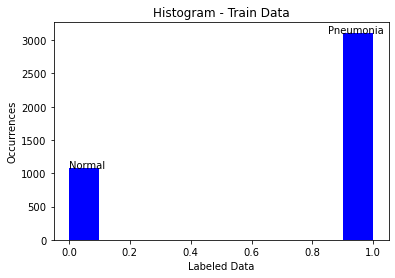

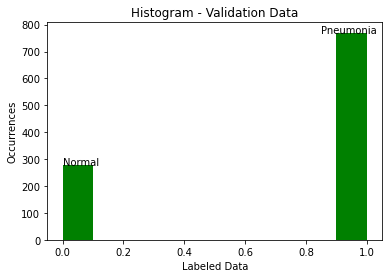

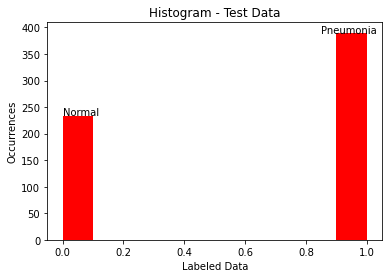

In [36]:
# Plotar histogramas
plt.hist(arry_hist_train, color = "blue")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Train Data")
plt.annotate("Normal", (0, norm_IMG_Train))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Train))
plt.show()

plt.hist(arry_hist_val, color = "green")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Validation Data")
plt.annotate("Normal", (0, norm_IMG_Val))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Val))
plt.show()

plt.hist(arry_hist_test, color = "red")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Test Data")
plt.annotate("Normal", (0, norm_IMG_Test))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Test))
plt.show()

# Construir o modelo CNN

In [75]:
inputs = Input(shape=(180, 180, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Sem Data Augmentation

In [76]:
x,y = get_train(0)
print(x.shape)
print(y.shape)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RSEED)

weight_for_0 = (1 / norm_IMG_Train)*(total_img_Train)/2.0 
weight_for_1 = (1 / pneu_IMG_Train)*(total_img_Train)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)
Weight for class 0: 1.95
Weight for class 1: 0.67


In [77]:
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]


opt = Adam(learning_rate=0.000001)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_95 (Conv2D)          (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 separable_conv2d (Separable  (None, 90, 90, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 90, 90, 32)       1344

In [78]:
history = model.fit(x_train, y_train,
            #steps_per_epoch=n_steps,
            epochs=n_epochs,
            validation_data = (x_val, y_val),
            verbose=1,
            class_weight=class_weights)

Epoch 1/25
131/131 [==============================] - 176s 1s/step - loss: 0.6938 - precision: 0.7443 - recall: 0.9753 - val_loss: 0.6931 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/25
131/131 [==============================] - 122s 913ms/step - loss: 0.6935 - precision: 0.7454 - recall: 0.9704 - val_loss: 0.6930 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
131/131 [==============================] - 144s 1s/step - loss: 0.6932 - precision: 0.7497 - recall: 0.9605 - val_loss: 0.6928 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/25
131/131 [==============================] - 138s 1s/step - loss: 0.6929 - precision: 0.7513 - recall: 0.9666 - val_loss: 0.6924 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
131/131 [==============================] - 141s 1s/step - loss: 0.6927 - precision: 0.7511 - recall: 0.9666 - val_loss: 0.6916 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 6/25
131/131 [==============================] - 136s 1s/step - loss: 0.6923 

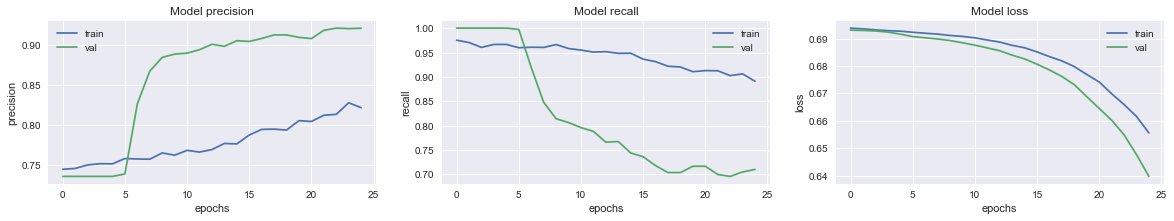

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    plt.savefig("Balanced.png")

In [80]:
x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

loss, prec, rec = model.evaluate(x_test,y_test)

F1 = 2 * (prec * rec) / (prec + rec)

print("Loss:",loss)
print("Precision: %.2f%%" % (prec*100))
print("Recall: %.2f%%" % (rec*100))
print("F1 Score: %.2f%%" % (F1*100))

ypred_bal = model.predict(x_test)

ypred_val_bal = np.array([1 if x > 0.5 else 0 for x in ypred_bal])

print(confusion_matrix(y_test, ypred_val_bal))
print('\n',classification_report(ypred_val_bal,y_test))

#ROC
FPR_B, TPR_B, Threshold_B = roc_curve(arry_hist_test, ypred_bal, pos_label=1)
#AUC
AUC_B = roc_auc_score(arry_hist_test, ypred_bal)

print('AUC Score:',AUC_B)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 180, 180, 3)
(624, 1)
20/20 [==============================] - 4s 207ms/step - loss: 0.6407 - precision: 0.8378 - recall: 0.7949
Loss: 0.6406691670417786
Precision: 83.78%
Recall: 79.49%
F1 Score: 81.58%
20/20 [==============================] - 5s 204ms/step
[[174  60]
 [ 80 310]]

               precision    recall  f1-score   support

           0       0.74      0.69      0.71       254
           1       0.79      0.84      0.82       370

    accuracy                           0.78       624
   macro avg       0.77      0.76      0.76       624
weighted avg       0.77      0.78      0.77       624

AUC Score: 0.8426912119219812


# Data Augmentation

In [64]:
x,y = get_train(0)
print(x.shape)
print(y.shape)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RSEED)

weight_for_0 = (1 / norm_IMG_Train)*(total_img_Train)/2.0 
weight_for_1 = (1 / pneu_IMG_Train)*(total_img_Train)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)
Weight for class 0: 1.95
Weight for class 1: 0.67


In [65]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True)  # randomly flip images

datagen.fit(x_train,seed=RSEED)

In [66]:
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]


opt = Adam(learning_rate=0.000001)

# Creating model and compiling
model_DA = Model(inputs=inputs, outputs=output)
model_DA.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
#model.summary()

In [67]:
history = model_DA.fit(x_train, y_train,
            #steps_per_epoch=n_steps,
            epochs=n_epochs,
            validation_data = (x_val, y_val),
            verbose=1,
            class_weight=class_weights)

Epoch 1/25
131/131 [==============================] - 67s 496ms/step - loss: 0.3079 - precision: 0.9754 - recall: 0.8526 - val_loss: 0.3228 - val_precision: 0.9715 - val_recall: 0.8416
Epoch 2/25
131/131 [==============================] - 64s 486ms/step - loss: 0.2980 - precision: 0.9766 - recall: 0.8596 - val_loss: 0.3450 - val_precision: 0.9785 - val_recall: 0.8273
Epoch 3/25
131/131 [==============================] - 62s 475ms/step - loss: 0.3027 - precision: 0.9754 - recall: 0.8538 - val_loss: 0.3210 - val_precision: 0.9701 - val_recall: 0.8429
Epoch 4/25
131/131 [==============================] - 63s 478ms/step - loss: 0.2986 - precision: 0.9752 - recall: 0.8590 - val_loss: 0.3335 - val_precision: 0.9772 - val_recall: 0.8351
Epoch 5/25
131/131 [==============================] - 62s 475ms/step - loss: 0.2992 - precision: 0.9744 - recall: 0.8561 - val_loss: 0.3175 - val_precision: 0.9702 - val_recall: 0.8455
Epoch 6/25
131/131 [==============================] - 62s 475ms/step - loss

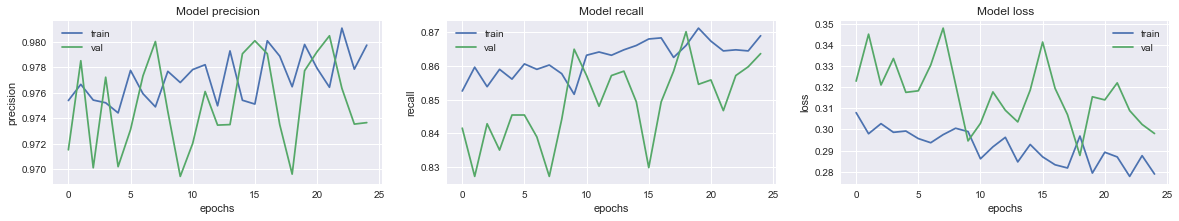

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()


for i, met in enumerate(['precision', 'recall', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    plt.savefig("balanced_data_aug.png")

In [69]:
x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

loss, prec, rec = model_DA.evaluate(x_test,y_test)

F1 = 2 * (prec * rec) / (prec + rec)

print("Loss:",loss)
print("Precision: %.2f%%" % (prec*100))
print("Recall: %.2f%%" % (rec*100))
print("F1 Score: %.2f%%" % (F1*100))

ypred_data_aug = model_DA.predict(x_test)

ypred_val_data_aug = np.array([1 if x > 0.5 else 0 for x in ypred_data_aug])

print(confusion_matrix(y_test, ypred_val_data_aug))
print('\n',classification_report(ypred_val_data_aug,y_test))

#ROC
FPR_DA, TPR_DA, Threshold_DA = roc_curve(arry_hist_test, ypred_data_aug, pos_label=1)
#AUC
AUC_DA = roc_auc_score(arry_hist_test, ypred_data_aug)

print('AUC Score:',AUC_DA)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 180, 180, 3)
(624, 1)
20/20 [==============================] - 2s 101ms/step - loss: 0.4112 - precision: 0.8480 - recall: 0.8872
Loss: 0.4112496078014374
Precision: 84.80%
Recall: 88.72%
F1 Score: 86.72%
20/20 [==============================] - 2s 93ms/step
[[172  62]
 [ 44 346]]

               precision    recall  f1-score   support

           0       0.74      0.80      0.76       216
           1       0.89      0.85      0.87       408

    accuracy                           0.83       624
   macro avg       0.81      0.82      0.82       624
weighted avg       0.83      0.83      0.83       624

AUC Score: 0.9163160201621741


# VGG19

Foto: https://www.researchgate.net/publication/342815128_machine_learning_knowledge_extraction_Focal_Liver_Lesion_Detection_in_Ultrasound_Image_Using_Deep_Feature_Fusions_and_Super_Resolution

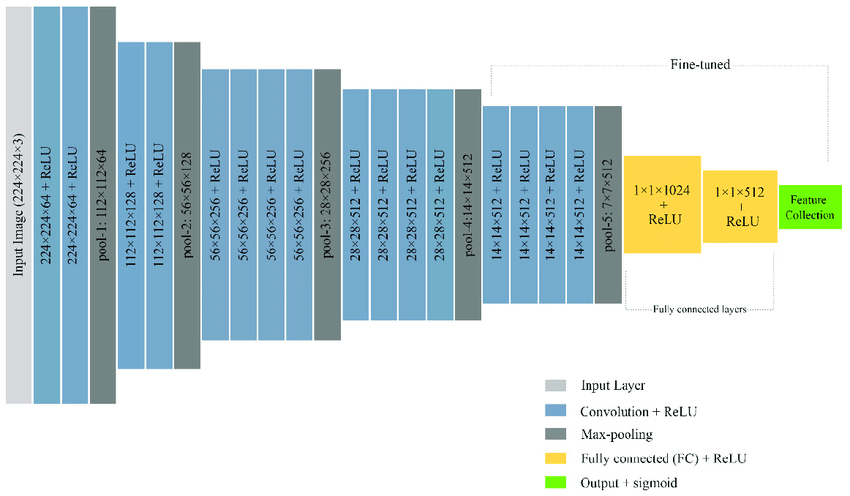

In [3]:
from IPython.display import Image
Image(filename='VGG19.png',width=800, height=400)

In [50]:
x,y = get_train(0)
print(x.shape)
print(y.shape)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RSEED)

weight_for_0 = (1 / norm_IMG_Train)*(total_img_Train)/2.0 
weight_for_1 = (1 / pneu_IMG_Train)*(total_img_Train)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)
Weight for class 0: 1.95
Weight for class 1: 0.67


In [51]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True)  # randomly flip images

datagen.fit(x_train,seed=RSEED)

In [52]:
from tensorflow.keras.layers.experimental import preprocessing

METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]


opt = tf.keras.optimizers.Adam(learning_rate=0.000001)

tf.keras.backend.clear_session()
input_shape = (180, 180, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1)                 12801     
                                                                 
Total params: 20,037,185
Trainable params: 12,801
Non-trainable params: 20,024,384
_________________________________________________________________


In [53]:
history = model_vgg19.fit(x_train,y_train,
        validation_data=(x_val,y_val),
        epochs=n_epochs,
        #steps_per_epoch=n_steps,
        shuffle=True, 
        verbose=True,
        class_weight=class_weights)

Epoch 1/25
131/131 [==============================] - 249s 2s/step - loss: 0.6821 - precision: 0.8889 - recall: 0.0334 - val_loss: 0.7607 - val_precision: 0.9667 - val_recall: 0.0753
Epoch 2/25
131/131 [==============================] - 238s 2s/step - loss: 0.6558 - precision: 0.9396 - recall: 0.1799 - val_loss: 0.7073 - val_precision: 0.9633 - val_recall: 0.2727
Epoch 3/25
131/131 [==============================] - 232s 2s/step - loss: 0.6377 - precision: 0.9439 - recall: 0.3784 - val_loss: 0.6720 - val_precision: 0.9541 - val_recall: 0.4584
Epoch 4/25
131/131 [==============================] - 229s 2s/step - loss: 0.6234 - precision: 0.9472 - recall: 0.5297 - val_loss: 0.6459 - val_precision: 0.9565 - val_recall: 0.6000
Epoch 5/25
131/131 [==============================] - 230s 2s/step - loss: 0.6109 - precision: 0.9478 - recall: 0.6421 - val_loss: 0.6269 - val_precision: 0.9383 - val_recall: 0.6714
Epoch 6/25
131/131 [==============================] - 232s 2s/step - loss: 0.5994 - p

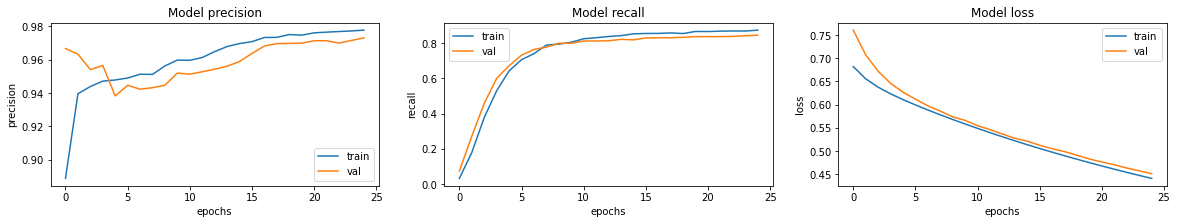

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    plt.savefig("VGG19_grafs.png")

In [55]:
x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

loss, prec, rec = model_vgg19.evaluate(x_test,y_test)

F1 = 2 * (prec * rec) / (prec + rec)

print("Loss:",loss)
print("Precision: %.2f%%" % (prec*100))
print("Recall: %.2f%%" % (rec*100))
print("F1 Score: %.2f%%" % (F1*100))

ypred_VGG19 = model_vgg19.predict(x_test)

ypred_val_VGG19 = np.array([1 if x > 0.5 else 0 for x in ypred_VGG19])

print(confusion_matrix(y_test, ypred_val_VGG19))
print('\n',classification_report(ypred_val_VGG19,y_test))

#ROC
FPR_VGG19, TPR_VGG19, Threshold_INCV3 = roc_curve(arry_hist_test, ypred_VGG19, pos_label=1)
#AUC
AUC_VGG19 = roc_auc_score(arry_hist_test, ypred_VGG19)

print('AUC Score:', AUC_VGG19)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 180, 180, 3)
(624, 1)
20/20 [==============================] - 27s 1s/step - loss: 0.4990 - precision: 0.8463 - recall: 0.8897
Loss: 0.4989582598209381
Precision: 84.63%
Recall: 88.97%
F1 Score: 86.75%
20/20 [==============================] - 27s 1s/step
[[171  63]
 [ 43 347]]

               precision    recall  f1-score   support

           0       0.73      0.80      0.76       214
           1       0.89      0.85      0.87       410

    accuracy                           0.83       624
   macro avg       0.81      0.82      0.82       624
weighted avg       0.84      0.83      0.83       624

AUC Score: 0.9098728906421214


# InceptionV3

Foto: https://www.researchgate.net/publication/349717475_Performance_Evaluation_of_Deep_CNN-Based_Crack_Detection_and_Localization_Techniques_for_Concrete_Structures

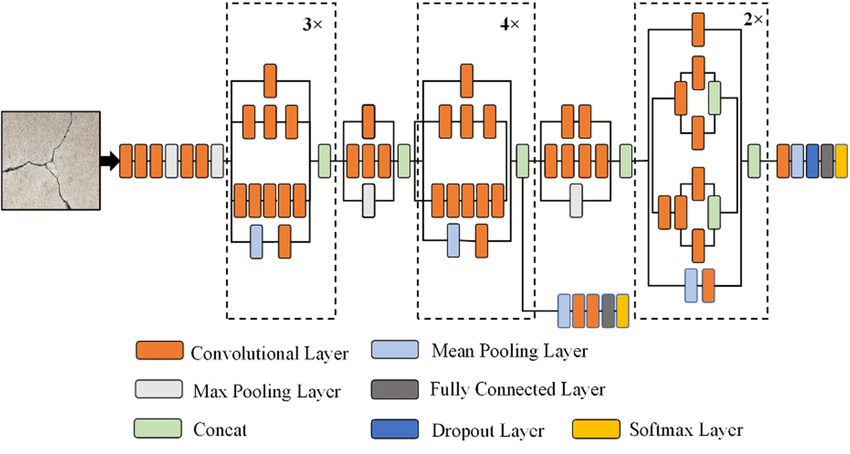

In [2]:
from IPython.display import Image
Image(filename='InceptionV3.png',width=800, height=400)

In [57]:
x,y = get_train(0)
print(x.shape)
print(y.shape)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RSEED)

weight_for_0 = (1 / norm_IMG_Train)*(total_img_Train)/2.0 
weight_for_1 = (1 / pneu_IMG_Train)*(total_img_Train)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)
Weight for class 0: 1.95
Weight for class 1: 0.67


In [58]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True)  # randomly flip images

datagen.fit(x_train,seed=RSEED)

In [59]:
from tensorflow.keras.layers.experimental import preprocessing

METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]


opt = tf.keras.optimizers.Adam(learning_rate=0.000001)

tf.keras.backend.clear_session()
input_shape = (180, 180, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
model_inceptionv3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 32769     
                                                                 
Total params: 21,835,553
Trainable params: 32,769
Non-trainable params: 21,802,784
_________________________________________________________________


In [60]:
history = model_inceptionv3.fit(x_train,y_train,
        validation_data=(x_val,y_val),
        epochs=n_epochs,
        #steps_per_epoch=n_steps,
        verbose=True,
        class_weight=class_weights)

Epoch 1/25
131/131 [==============================] - 56s 396ms/step - loss: 0.8786 - precision: 0.7513 - recall: 0.4337 - val_loss: 0.8139 - val_precision: 0.7741 - val_recall: 0.5117
Epoch 2/25
131/131 [==============================] - 51s 387ms/step - loss: 0.7052 - precision: 0.8234 - recall: 0.5901 - val_loss: 0.6654 - val_precision: 0.8426 - val_recall: 0.6117
Epoch 3/25
131/131 [==============================] - 51s 387ms/step - loss: 0.5862 - precision: 0.8723 - recall: 0.6736 - val_loss: 0.5685 - val_precision: 0.8880 - val_recall: 0.6896
Epoch 4/25
131/131 [==============================] - 51s 388ms/step - loss: 0.5023 - precision: 0.8991 - recall: 0.7527 - val_loss: 0.4931 - val_precision: 0.9095 - val_recall: 0.7571
Epoch 5/25
131/131 [==============================] - 50s 386ms/step - loss: 0.4428 - precision: 0.9214 - recall: 0.7870 - val_loss: 0.4368 - val_precision: 0.9275 - val_recall: 0.7974
Epoch 6/25
131/131 [==============================] - 51s 388ms/step - loss

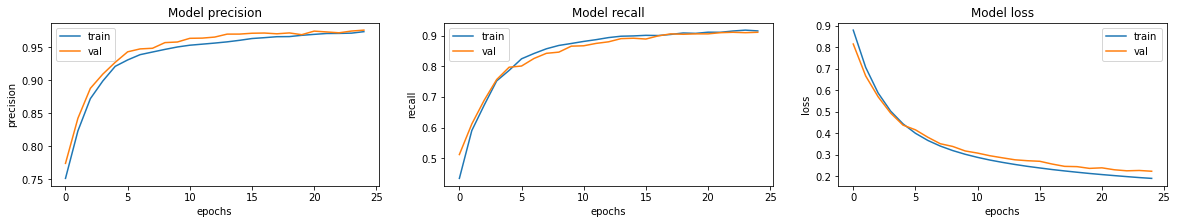

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()


for i, met in enumerate(['precision', 'recall', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    plt.savefig("InceptionV3_grafs.png")

In [62]:
x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

loss, prec, rec = model_inceptionv3.evaluate(x_test,y_test)

F1 = 2 * (prec * rec) / (prec + rec)

print("Loss:",loss)
print("Precision: %.2f%%" % (prec*100))
print("Recall: %.2f%%" % (rec*100))
print("F1 Score: %.2f%%" % (F1*100))

ypred_InceptionV3 = model_inceptionv3.predict(x_test)

ypred_val_InceptionV3 = np.array([1 if x > 0.5 else 0 for x in ypred_InceptionV3])


print(confusion_matrix(y_test, ypred_val_InceptionV3))
print('\n',classification_report(ypred_val_VGG19,ypred_val_InceptionV3))

#ROC
FPR_INCV3, TPR_INCV3, Threshold_INCV3 = roc_curve(arry_hist_test, ypred_InceptionV3, pos_label=1)
#AUC
AUC_INCV3 = roc_auc_score(arry_hist_test, ypred_InceptionV3)

print('AUC Score:', AUC_INCV3)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_9276\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 180, 180, 3)
(624, 1)
20/20 [==============================] - 7s 327ms/step - loss: 0.4123 - precision: 0.8133 - recall: 0.9385
Loss: 0.41231751441955566
Precision: 81.33%
Recall: 93.85%
F1 Score: 87.14%
20/20 [==============================] - 7s 310ms/step
[[150  84]
 [ 24 366]]

               precision    recall  f1-score   support

           0       0.79      0.64      0.71       214
           1       0.83      0.91      0.87       410

    accuracy                           0.82       624
   macro avg       0.81      0.78      0.79       624
weighted avg       0.82      0.82      0.82       624

AUC Score: 0.903243480166557


**Gráficos ROC e valores de AUC**

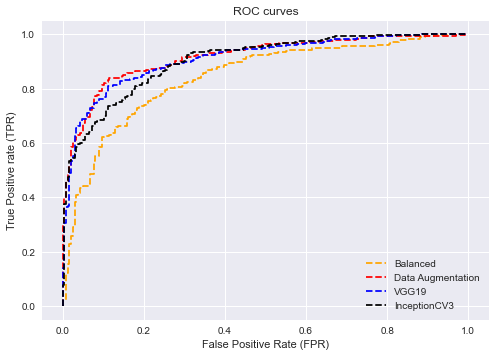

AUC Balanced: 0.8427
AUC Data Augmentation: 0.9163
AUC VGG19: 0.9099
AUC InceptionV3 0.9032


In [81]:
plt.style.use('seaborn')

plt.plot(FPR_B, TPR_B, linestyle='--',color='orange', label='Balanced')
plt.plot(FPR_DA, TPR_DA, linestyle='--',color='red', label='Data Augmentation')
plt.plot(FPR_VGG19, TPR_VGG19, linestyle='--',color='blue', label='VGG19')
plt.plot(FPR_INCV3, TPR_INCV3, linestyle='--',color='black', label='InceptionCV3')

plt.title('ROC curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive rate (TPR)')
plt.legend(loc='lower right')
plt.savefig("ROC.png")
plt.show()


print("AUC Balanced:", round(AUC_B,4))
print("AUC Data Augmentation:", round(AUC_DA,4))
print("AUC VGG19:", round(AUC_VGG19,4))
print("AUC InceptionV3", round(AUC_INCV3,4))